# PyTorch Lab 6

Written by Prachya Boonkwan (Arm)

In [0]:
!pip install -q http://download.pytorch.org/whl/cpu/torch-0.4.1-cp36-cp36m-linux_x86_64.whl torchvision tqdm nltk
import nltk

## Header

This part is the header of the code. My favorite import aliases for PyTorch are as follows. This will be very useful for speed coding.

In [2]:
#!/usr/bin/env python3
#-*- coding: utf-8 -*-

import torch as T
import torch.nn as N
import torch.optim as O

from tqdm import tqdm    # Nice progressbar
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline

import math, random

if T.cuda.is_available():
    print('Feel free to use GPU acceleration.')
else:
    print('GPU is not available at this time.')

use_cuda = True   # False

GPU is not available at this time.




---



## Data Preparation

### Generating Synthetic Parallel Text from Synchronous Grammar

In [0]:
grammar_flags = {
    # Phrase Patterns
    'allow_pp'    : False,     # NP recursion
    'allow_relc'  : False,     # VP recursion
    'allow_subcls': False,     # S recursion
    'allow_conj'  : False,     # All-round recursion
    
    # Translation ambiguity
    'one-to-many translation' : True,
    'many-to-one translation' : True,
    'many-to-many translation': True,
    
    # Categorical ambiguity
    'one-to-one category'  : False,
    'many-to-one category' : False,
    'one-to-many category' : False,
    'many-to-many category': False,
}

In [0]:
no_content_words = 20
no_function_words = 5
no_lexical_ambiguity = 3

no_sents = 10000
min_sentlen = 5
max_sentlen = 21

In [0]:
grammar = [
    # Pattern of sentence
    ('<S>', '<NP> <VP>'.split(), [0, 1]),
    ('<S>', '<VP>'.split(), [0]),
    
    # Noun phrase
    ('<NP>', '<ADJ> <NP>'.split(), [0, 1]),
    ('<NP>', '<NP> <ADJ>'.split(), [1, 0]),
    ('<NP>', '<N>'.split(), [0]),
    ('<NP>', '<N> <N>'.split(), [1, 0]),
    
    # Verb phrase
    ('<VP>', '<ADV> <VP>'.split(), [0, 1]),
    ('<VP>', '<VP> <ADV>'.split(), [1, 0]),
    ('<VP>', '<V>'.split(), [0]),
    ('<VP>', '<V> <NP>'.split(), [1, 0]),
    
    # Relative clause
    ('<RELC>', '<RELPRO> <S>'.split(), [1, 0]),
    
    # Preposition phrase
    ('<PP>', '<PREP> <NP>'.split(), [1, 0]),
]

lexicons = {}
lexicons['<N>'] = []
lexicons['<V>'] = []
lexicons['<ADJ>'] = []
lexicons['<ADV>'] = []
lexicons['<PREP>'] = []
lexicons['<RELPRO>'] = []
lexicons['<CONJ>'] = []
lexicons['<SUBCONJ>'] = []

for i in range(no_content_words):
    lexicons['<N>'].append((['na:{}'.format(i)], ['nb:{}'.format(i)]))
    lexicons['<V>'].append((['va:{}'.format(i)], ['vb:{}'.format(i)]))
    lexicons['<ADJ>'].append((['ja:{}'.format(i)], ['jb:{}'.format(i)]))
    lexicons['<ADV>'].append((['ra:{}'.format(i)], ['rb:{}'.format(i)]))

for i in range(no_function_words):
    lexicons['<PREP>'].append((['pa:{}'.format(i)], ['pb:{}'.format(i)]))
    lexicons['<RELPRO>'].append((['ca:{}'.format(i)], ['cb:{}'.format(i)]))
    lexicons['<CONJ>'].append((['&a:{}'.format(i)], ['&b:{}'.format(i)]))
    lexicons['<SUBCONJ>'].append((['sa:{}'.format(i)], ['sb:{}'.format(i)]))

In [0]:
if grammar_flags['allow_conj']:
    grammar.append(('<S>', '<S> <CONJ> <S>'.split(), [0, 1, 2]))
    grammar.append(('<NP>', '<NP> <CONJ> <NP>'.split(), [0, 1, 2]))
    grammar.append(('<VP>', '<VP> <CONJ> <VP>'.split(), [0, 1, 2]))

if grammar_flags['allow_pp']:
    grammar.append(('<NP>', '<NP> <PP>'.split(), [1, 0]))
    grammar.append(('<VP>', '<VP> <PP>'.split(), [1, 0]))
    grammar.append(('<S>', '<PP> <NP> <VP>'.split(), [0, 1, 2]))
    grammar.append(('<S>', '<PP> <VP>'.split(), [0, 1]))
    
if grammar_flags['allow_relc']:
    grammar.append(('<NP>', '<NP> <RELC>'.split(), [1, 0]))
    
if grammar_flags['allow_subcls']:
    grammar.append(('<S>', '<S> <SUBCONJ> <S>'.split(), [2, 1, 0]))
    
if grammar_flags['one-to-many translation']:
    lexicons['<N>'].append((['naom'], ['nbom:{}'.format(i + 1) for i in range(no_lexical_ambiguity)]))
    lexicons['<V>'].append((['vaom'], ['vbom:{}'.format(i + 1) for i in range(no_lexical_ambiguity)]))
    lexicons['<ADJ>'].append((['jaom'], ['jbom:{}'.format(i + 1) for i in range(no_lexical_ambiguity)]))
    lexicons['<ADV>'].append((['raom'], ['rbom:{}'.format(i + 1) for i in range(no_lexical_ambiguity)]))
    
if grammar_flags['many-to-one translation']:
    lexicons['<N>'].append((['namo:{}'.format(i + 1) for i in range(no_lexical_ambiguity)], ['nbmo']))
    lexicons['<V>'].append((['vamo:{}'.format(i + 1) for i in range(no_lexical_ambiguity)], ['vbmo']))
    lexicons['<ADJ>'].append((['jamo:{}'.format(i + 1) for i in range(no_lexical_ambiguity)], ['jbmo']))
    lexicons['<ADV>'].append((['ramo:{}'.format(i + 1) for i in range(no_lexical_ambiguity)], ['rbmo']))
    
if grammar_flags['many-to-many translation']:
    lexicons['<N>'].append((['namm:{}'.format(i + 1) for i in range(no_lexical_ambiguity)], ['nbmm:{}'.format(i + 1) for i in range(no_lexical_ambiguity)]))
    lexicons['<V>'].append((['vamm:{}'.format(i + 1) for i in range(no_lexical_ambiguity)], ['vbmm:{}'.format(i + 1) for i in range(no_lexical_ambiguity)]))
    lexicons['<ADJ>'].append((['jamm:{}'.format(i + 1) for i in range(no_lexical_ambiguity)], ['jbmm:{}'.format(i + 1) for i in range(no_lexical_ambiguity)]))
    lexicons['<ADV>'].append((['ramm:{}'.format(i + 1) for i in range(no_lexical_ambiguity)], ['rbmm:{}'.format(i + 1) for i in range(no_lexical_ambiguity)]))
    
if grammar_flags['one-to-one category']:
    lexicons['<N>'].append((['nvaooc'], ['nbooc']))
    lexicons['<V>'].append((['nvaooc'], ['vbooc']))
    lexicons['<ADJ>'].append((['jraooc'], ['jbooc']))
    lexicons['<ADV>'].append((['jraooc'], ['rbooc']))
    
if grammar_flags['one-to-many category']:
    lexicons['<N>'].append((['nvaomc'], ['nbomc:{}'.format(i) for i in range(no_lexical_ambiguity)]))
    lexicons['<V>'].append((['nvaomc'], ['vbomc:{}'.format(i) for i in range(no_lexical_ambiguity)]))
    lexicons['<ADJ>'].append((['jraomc'], ['jbomc:{}'.format(i) for i in range(no_lexical_ambiguity)]))
    lexicons['<ADV>'].append((['jraomc'], ['rbomc:{}'.format(i) for i in range(no_lexical_ambiguity)]))
    
if grammar_flags['many-to-one category']:
    lexicons['<N>'].append((['nvamoc:{}'.format(i) for i in range(no_lexical_ambiguity)], ['nbmoc']))
    lexicons['<V>'].append((['nvamoc:{}'.format(i) for i in range(no_lexical_ambiguity)], ['vbmoc']))
    lexicons['<ADJ>'].append((['jramoc:{}'.format(i) for i in range(no_lexical_ambiguity)], ['jbmoc']))
    lexicons['<ADV>'].append((['jramoc:{}'.format(i) for i in range(no_lexical_ambiguity)], ['rbmoc']))
    
if grammar_flags['many-to-many category']:
    lexicons['<N>'].append((['nvammc:{}'.format(i) for i in range(no_lexical_ambiguity)], ['nbmmc:{}'.format(i) for i in range(no_lexical_ambiguity)]))
    lexicons['<V>'].append((['nvammc:{}'.format(i) for i in range(no_lexical_ambiguity)], ['vbmmc:{}'.format(i) for i in range(no_lexical_ambiguity)]))
    lexicons['<ADJ>'].append((['jrammc:{}'.format(i) for i in range(no_lexical_ambiguity)], ['jbmmc:{}'.format(i) for i in range(no_lexical_ambiguity)]))
    lexicons['<ADV>'].append((['jrammc:{}'.format(i) for i in range(no_lexical_ambiguity)], ['rbmmc:{}'.format(i) for i in range(no_lexical_ambiguity)]))

In [0]:
grmtbl = {}
for (lhs, rhs1, rhs2) in grammar:
    if lhs not in grmtbl:
        grmtbl[lhs] = set()
    grmtbl[lhs].add((tuple(rhs1), tuple(rhs2)))
    
lextbl = {}
for lhs in lexicons:
    if lhs not in lextbl:
        lextbl[lhs] = set()
    for (words1, words2) in lexicons[lhs]:
        for word1 in words1:
            for word2 in words2:
                lextbl[lhs].add((word1, word2))

for lhs in grmtbl:
    grmtbl[lhs] = list(grmtbl[lhs])
for lhs in lextbl:
    lextbl[lhs] = list(lextbl[lhs])

In [0]:
class MaximumRecursionOfSynchronousGrammar(Exception):
    pass

def gen_bistring(tag, depth=0, depth_limit=8):
    choices = []
    if tag in lextbl:
        choices.extend(lextbl[tag])
    if tag in grmtbl and depth <= depth_limit:
        choices.extend(grmtbl[tag])
    random.shuffle(choices)
    
    if len(choices) == 0:
        raise MaximumRecursionOfSynchronousGrammar()

    for choice in choices:
        (srctags, destidxs) = choice
        
        if isinstance(srctags, str):
            return ([srctags], [destidxs])
        
        try:
            result = {}
            srcsent, destsent = [], []
            for i in range(len(srctags)):
                (srctokens, desttokens) = gen_bistring(
                    srctags[i], depth=depth+1, depth_limit=depth_limit
                )
                srcsent.extend(srctokens)
                result[i] = desttokens
            for destidx in destidxs:
                destsent.extend(result[destidx])
            return (srcsent, destsent)
        except MaximumRecursionOfSynchronousGrammar: continue
            
    raise MaximumRecursionOfSynchronousGrammar()

In [9]:
srcsent, destsent = gen_bistring('<S>')
print(srcsent)
print(destsent)

['va:12', 'namm:1', 'na:0']
['nb:0', 'nbmm:1', 'vb:12']


In [10]:
corpus = []
for i in range(no_sents):
    while True:
        srcsent, destsent = gen_bistring('<S>')
        if min_sentlen <= len(srcsent) < max_sentlen: break
    corpus.append((srcsent, destsent))
random.shuffle(corpus)

crplen = len(corpus)
print('Number of translation pairs = {}'.format(crplen))

no_words_lang1 = sum(
    len(sent1)
    for (sent1, sent2) in corpus
)
print('Total number of Lang1 words = {}'.format(no_words_lang1))

no_words_lang2 = sum(
    len(sent2)
    for (sent1, sent2) in corpus
)
print('Total number of Lang2 words = {}'.format(no_words_lang2))

Number of translation pairs = 10000
Total number of Lang1 words = 68751
Total number of Lang2 words = 68751


### Indexing Words and Intents

In [0]:
all_words = {0: set(), 1: set()}

for (sent1, sent2) in corpus:
    all_words[0].update(set(sent1))
    all_words[1].update(set(sent2))

In [12]:
idx2word = {}
idx2word[0] = [None] + sorted(all_words[0])
idx2word[1] = [None] + sorted(all_words[1])

no_words = {}
no_words[0] = len(idx2word[0])
no_words[1] = len(idx2word[1])
print('Number of Lang1 words = {}'.format(no_words[0]))
print('Number of Lang2 words = {}'.format(no_words[1]))

Number of Lang1 words = 109
Number of Lang2 words = 109


In [13]:
word2idx = {0: {}, 1: {}}

for i in idx2word:
    for (idx, word) in enumerate(idx2word[i]):
        word2idx[i][word] = idx

print(len(word2idx[0]))
print(len(word2idx[1]))

109
109


### Conversion between Sentence and Index Sequence

In [0]:
def sent2idxseq(langid, sent):
    wordidxseq = []
    for word in sent:
        word = word.lower()
        if word in word2idx[langid]:
            wordidxseq.append(word2idx[langid][word])
        else:
            wordidxseq.append(word2idx[langid][None])
    return wordidxseq

def sents2idxseqs(langid, sents):
    return [sent2idxseq(langid, sent) for sent in sents]

In [15]:
wordidxseq1 = sent2idxseq(0, corpus[0][0])
print(wordidxseq1)

wordidxseq2 = sent2idxseq(1, corpus[0][1])
print(wordidxseq2)

[103, 36, 21, 81, 76, 71]
[71, 77, 79, 21, 36, 102]


In [0]:
def idxseq2sent(langid, wordidxseq):
    result = []
    for i in range(len(wordidxseq)):
        wordidx = wordidxseq[i]
        if wordidx < len(idx2word[langid]):
            word = idx2word[langid][wordidx]
            if word is not None:
                result.append(word)
    return result

def idxseqs2sents(langid, wordidxseqs):
    return [idxseq2sent(langid, wordidxseq) for wordidxseq in wordidxseqs]

In [17]:
s = idxseq2sent(0, wordidxseq1)
print(s)

s = idxseq2sent(1, wordidxseq2)
print(s)

['vamm:2', 'na:16', 'jamm:1', 'raom', 'ramm:2', 'ra:6']
['rb:6', 'rbmm:3', 'rbom:1', 'jbmm:1', 'nb:16', 'vbmm:1']




---



### Preparing Training and Testing Sets

In [0]:
def corpus2dataset(corpus):
    dataset = []
    for (sent1, sent2) in corpus:
        wordidxseq1 = sent2idxseq(0, sent1)
        wordidxseq2 = sent2idxseq(1, sent2)
        dataset.append((wordidxseq1, wordidxseq2))
    return dataset

In [19]:
crp = [ (corpus[0][0], corpus[0][1]),
        (corpus[1][0], corpus[1][1]),
      ]
ds = corpus2dataset(crp)
print(ds)

[([103, 36, 21, 81, 76, 71], [71, 77, 79, 21, 36, 102]), ([54, 59, 69, 97, 21, 32, 27], [53, 59, 69, 23, 25, 32, 97])]


In [20]:
training_len = int(crplen * 0.8)           # 80% for training, 20% for testing
training_set = corpus2dataset(corpus[: training_len])
testing_set = corpus2dataset(corpus[training_len :])
print('Size of training set = {}'.format(len(training_set)))
print('Size of testing set = {}'.format(len(testing_set)))

Size of training set = 8000
Size of testing set = 2000




---



## Neural Machine Translation

### Encoder

In [0]:
class Encoder(N.Module):
    
    def __init__(self, no_words, dim_word, dim_hidden, num_layers, maxlen=256):
        super(Encoder, self).__init__()
        
        self._no_words = no_words
        self._dim_word = dim_word
        self._dim_hidden = dim_hidden
        self._num_layers = num_layers
        self._maxlen = maxlen
        self._batch_first = True
        
        self._wordemb = N.Embedding(self._no_words, self._dim_word)
        self._gru = N.GRU(
            self._dim_word, self._dim_hidden, self._num_layers, 
            batch_first=self._batch_first, bidirectional=True
        )
        self.output_size = 2 * self._dim_hidden
        
    def forward(self, wordidx, hidden=None):
        if hidden is None: hidden = T.zeros(2, 1, self._dim_hidden)
            
        wordvec = self._wordemb(T.LongTensor([wordidx])).view(1, 1, -1)
        ctxvec, hidden = self._gru(wordvec, hidden)
        return ctxvec.squeeze(0), hidden
    
    def forward_seq(self, wordidxseq):
        encoder_vecs = T.zeros(self._maxlen, 2 * self._dim_hidden)
        hidden = None
        for i in range(len(wordidxseq)):
            ctxvec, hidden = self.forward(wordidxseq[i], hidden)
            encoder_vecs[i] = ctxvec
        return encoder_vecs, hidden

In [22]:
enc = Encoder(no_words[0], 8, 5, 1)
wordvec, hidden = enc(8)
print('wordvec =\n{}'.format(wordvec))
print('hidden =\n{}'.format(hidden))

wordvec =
tensor([[-0.5686,  0.4176, -0.2037, -0.3592, -0.1200, -0.1325, -0.6865, -0.3748,
          0.3442, -0.0607]], grad_fn=<SqueezeBackward1>)
hidden =
tensor([[[-0.5686,  0.4176, -0.2037, -0.3592, -0.1200]],

        [[-0.1325, -0.6865, -0.3748,  0.3442, -0.0607]]],
       grad_fn=<ViewBackward>)


In [23]:
encoder_vecs, hidden = enc.forward_seq([1, 2, 3])
print('encoder_vecs =\n{}'.format(encoder_vecs))
print('hidden =\n{}'.format(hidden))

encoder_vecs =
tensor([[-0.4885, -0.2405, -0.0205,  ..., -0.1126, -0.0032, -0.2634],
        [-0.1679, -0.0493,  0.3072,  ...,  0.0177,  0.0592, -0.2831],
        [-0.3891, -0.1155,  0.2833,  ...,  0.0050,  0.2684, -0.3834],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<CopySlices>)
hidden =
tensor([[[-0.3891, -0.1155,  0.2833,  0.2231,  0.2242]],

        [[ 0.0444,  0.3032,  0.0050,  0.2684, -0.3834]]],
       grad_fn=<ViewBackward>)


### Decoder

In [0]:
class Decoder(N.Module):
    
    def __init__(self, no_words, dim_word, dim_hidden, num_layers, dropout=0.2, maxlen=256):
        super(Decoder, self).__init__()
        
        self._no_words = no_words
        self._dim_word = dim_word
        self._dim_hidden = dim_hidden
        self._num_layers = num_layers
        self._dropout = dropout
        self._maxlen = maxlen
        self._batch_first = True
        
        self._wordemb = N.Embedding(self._no_words, self._dim_word)
        self._droplay = N.Dropout(self._dropout)
        self._attn = N.Linear(self._dim_word + self._dim_hidden, self._maxlen)
        self._combine = N.Linear(self._dim_word + 2 * self._dim_hidden, self._dim_hidden)
        self._relu = N.ReLU()
        self._gru = N.GRU(
            self._dim_hidden, self._dim_hidden, self._num_layers,
            batch_first=self._batch_first
        )
        self._output = N.Linear(self._dim_hidden, self._no_words)
        
        self._softmax = N.Softmax(dim=1)
        
    def forward(self, wordidx, encoder_vecs, hidden=None):
        if hidden is None: hidden = T.zeros(1, 1, self._dim_hidden)
        
        wordvec = self._wordemb(T.LongTensor([wordidx])).view(1, 1, -1)
        wordvec = self._droplay(wordvec)
        
        word_and_hid = T.cat([wordvec[0], hidden[0]], dim=1)
        attn_weights = self._softmax(self._attn(word_and_hid))
        attn_applied = T.matmul(attn_weights, encoder_vecs)
        
        word_and_attn = T.cat([wordvec[0], attn_applied], dim=1)
        combined = self._relu(self._combine(word_and_attn))
        
        outpat, next_hidden = self._gru(combined.unsqueeze(0), hidden)
        output = self._output(outpat)
        
        return output, next_hidden, attn_weights

In [25]:
dec = Decoder(no_words[1], 8, 5, 1)
output, hidden, attn_weights = dec.forward(1, encoder_vecs)
print('output =\n{}'.format(output))
print('hidden =\n{}'.format(hidden))
print('attn_weights =\n{}'.format(attn_weights))

output =
tensor([[[ 0.1868,  0.2725,  0.0257, -0.1271,  0.1434,  0.4651, -0.1306,
           0.5829,  0.0457, -0.2169,  0.0414, -0.3215, -0.3122, -0.3888,
           0.0922,  0.3446,  0.2575, -0.1020, -0.2760,  0.0644, -0.4069,
          -0.0585,  0.2286,  0.1232,  0.1089, -0.0615, -0.4187, -0.1793,
          -0.3463, -0.2924,  0.4442, -0.0938,  0.0472,  0.3012, -0.2815,
           0.1468, -0.1004,  0.2993,  0.1783, -0.1870, -0.3068,  0.3753,
           0.4582, -0.2327,  0.0175, -0.1501, -0.2922,  0.4180,  0.4266,
           0.2804,  0.3051, -0.4253,  0.2643, -0.0564,  0.4575, -0.2255,
          -0.2954,  0.1755,  0.4387,  0.0278,  0.1735, -0.1998, -0.0971,
           0.4196, -0.3043,  0.2831, -0.0342,  0.1612,  0.2781,  0.3502,
          -0.1138,  0.3663,  0.1181,  0.2107,  0.2494,  0.0105, -0.0801,
          -0.5489,  0.3424,  0.2707,  0.1542, -0.3715, -0.1573,  0.0055,
           0.1788,  0.2299,  0.1518,  0.1852, -0.2306, -0.1514, -0.0392,
          -0.3064,  0.0434, -0.2462, -0.40

### Neural Architecture

In [0]:
class NMT(N.Module):
    
    def __init__(
        self, no_words_1, no_words_2, dim_word_1, dim_word_2, dim_hidden,
        num_layers_1=1, num_layers_2=1, dropout=0.2, maxlen=256
    ):
        super(NMT, self).__init__()
        self._no_words_1 = no_words_1
        self._no_words_2 = no_words_2
        self._dim_word_1 = dim_word_1
        self._dim_word_2 = dim_word_2
        self._dim_hidden = dim_hidden
        self._num_layers_1 = num_layers_1
        self._num_layers_2 = num_layers_2
        self._dropout = dropout
        self._maxlen = maxlen
        self._batch_first = True
        
        self._encoder = Encoder(
            self._no_words_1, self._dim_word_1, self._dim_hidden, self._num_layers_1, maxlen=self._maxlen
        )
        self._decoder = Decoder(
            self._no_words_2, self._dim_word_2, self._dim_hidden, self._num_layers_2, dropout=self._dropout, maxlen=self._maxlen
        )
        
    def encode(self, srcwordidx, hidden=None):
        return self._encoder.forward(srcwordidx, hidden)
        
    def encode_seq(self, srcsent):
        return self._encoder.forward_seq(srcsent)
    
    def decode(self, destwordidx, encoder_vecs, hidden=None):
        return self._decoder.forward(destwordidx, encoder_vecs, hidden)

In [27]:
nmt_model = NMT(no_words[0], no_words[1], 8, 8, 5, maxlen=max_sentlen)
print(nmt_model); print()

encoder_vecs, hidden = nmt_model.encode_seq([1, 2, 3])
print('encoder_vecs =\n{}'.format(encoder_vecs))
print('hidden =\n{}'.format(hidden)); print()

output, hidden, attn_weights = nmt_model.decode(1, encoder_vecs)
print('output =\n{}'.format(output))
print('hidden =\n{}'.format(hidden))
print('attn_weights =\n{}'.format(attn_weights))

NMT(
  (_encoder): Encoder(
    (_wordemb): Embedding(109, 8)
    (_gru): GRU(8, 5, batch_first=True, bidirectional=True)
  )
  (_decoder): Decoder(
    (_wordemb): Embedding(109, 8)
    (_droplay): Dropout(p=0.2)
    (_attn): Linear(in_features=13, out_features=21, bias=True)
    (_combine): Linear(in_features=18, out_features=5, bias=True)
    (_relu): ReLU()
    (_gru): GRU(5, 5, batch_first=True)
    (_output): Linear(in_features=5, out_features=109, bias=True)
    (_softmax): Softmax()
  )
)

encoder_vecs =
tensor([[ 0.2669, -0.4954,  0.1485,  0.3098,  0.5030,  0.4468, -0.3046,  0.3676,
          0.4714,  0.2289],
        [ 0.2922,  0.1748, -0.3942,  0.5711, -0.4227, -0.2181, -0.3993,  0.4925,
         -0.0360,  0.3183],
        [ 0.0565,  0.1070, -0.1981,  0.6866, -0.6086,  0.2259, -0.7439,  0.6156,
         -0.0765, -0.0411],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  



---



### Online Training

In [0]:
teacher_forcing_rate = 0.5

def train_sentpair(
    nmt_model, srcsent, destsent, destpadidx, loss_fn, 
    encoder_opt, decoder_opt, gradthr=50.0
):
    encoder_opt.zero_grad()
    decoder_opt.zero_grad()
    
    encoder_vecs, hidden = nmt_model.encode_seq(srcsent)
    decinput = T.LongTensor([destpadidx])
    dechid = None
    desttsr = T.LongTensor(destsent)
    loss = 0.0
    
    teacher_forcing = True if random.random() < teacher_forcing_rate else False
    
    if teacher_forcing:
        for i in range(len(destsent)):
            decout, dechid, decattn = nmt_model.decode(decinput, encoder_vecs, dechid)
            decout = decout.squeeze(0)
            loss += loss_fn(decout, T.LongTensor([desttsr[i]]))
    else:
        for i in range(len(destsent)):
            decout, dechid, decattn = nmt_model.decode(decinput, encoder_vecs, dechid)
            decout = decout.squeeze(0)
            top_v, top_i = decout.topk(1)
            decinput = top_i.squeeze().detach()
            loss += loss_fn(decout, T.LongTensor([desttsr[i]]))
            if decinput.item() == destpadidx: break
    
    # Backpropagation
    loss.backward()
    
    # Gradient clipping
    N.utils.clip_grad_norm_(nmt_model._encoder.parameters(), gradthr)
    N.utils.clip_grad_norm_(nmt_model._decoder.parameters(), gradthr)
    
    # Parameter adjustment
    encoder_opt.step()
    decoder_opt.step()
    
    return loss / len(destsent)

In [0]:
def train_model(
    nmt_model, srclangid, destlangid, training_data, epochs, loss_fn,
    learning_rate, gradthr=50.0
):
    no_samples = len(training_data)
    loss_history = []
    srcpadidx = word2idx[srclangid][None]
    destpadidx = word2idx[destlangid][None]
    
    encoder_opt = O.Adam(nmt_model._encoder.parameters(), lr=learning_rate)
    decoder_opt = O.Adam(nmt_model._decoder.parameters(), lr=learning_rate)
    
    for i in range(epochs):
        random.shuffle(training_data)
        total_loss = 0.0
        for j in tqdm(range(len(training_data)), desc='Iter {}'.format(i + 1)):
            srcsent = training_data[j][srclangid] + [srcpadidx]
            destsent = training_data[j][destlangid] + [destpadidx]
            loss = train_sentpair(
                nmt_model, srcsent, destsent, destpadidx, loss_fn,
                encoder_opt, decoder_opt, gradthr
            )
            total_loss += loss.item()
        loss_history.append(total_loss / len(training_data))

    # Plot the loss history with Matplotlib
    epoch_count = range(1, epochs + 1)
    plt.plot(epoch_count, loss_history, 'b--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Iter 20: 100%|██████████| 8000/8000 [03:08<00:00, 42.38it/s]


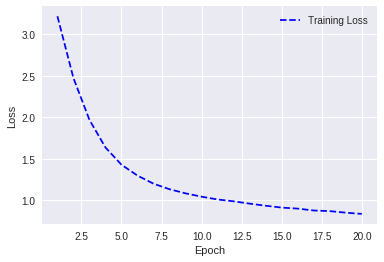

In [30]:
nmt_model = NMT(no_words[0], no_words[1], 10, 10, 100, maxlen=max_sentlen)

if use_cuda and T.cuda.is_available():
    nmt_model.cuda()

epochs = 20
learning_rate = 0.001

loss_fn = N.CrossEntropyLoss()
train_model(
    nmt_model, 0, 1, training_set, epochs, loss_fn, learning_rate
)



---



### Decoding

In [0]:
def decode(nmt_model, srclangid, destlangid, wordidxseq, maxlen):
    srcpadidx = word2idx[srclangid][None]
    destpadidx = word2idx[destlangid][None]
    encoder_vecs, hidden = nmt_model.encode_seq(wordidxseq + [srcpadidx])
    
    decinput = T.LongTensor([destpadidx])
    dechid = None
    trans, attn = [], []
    
    for i in range(maxlen):
        decout, dechid, decattn = nmt_model.decode(decinput, encoder_vecs, dechid)
        top_v, top_i = decout.topk(1)
        decinput = top_i.squeeze().detach()
        wordidx = decinput.item()
        if wordidx == destpadidx:
            break
        else:
            trans.append(wordidx)
            attn.append(decattn.detach())
            
    return trans, T.cat(attn)

srcsent = "na:19 va:0 na:3 na:4 ja:7"
translation = "nb:19 jb:7 nb:4 nb:3 vb:0"
attn = "torch.Size([5, 21])"


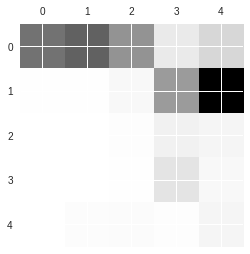

In [33]:
srcsent = corpus[3][0]
print('srcsent = "{}"'.format(' '.join(srcsent)))
wordidxseq = sent2idxseq(0, srcsent)
trans, attn = decode(nmt_model, 0, 1, wordidxseq, 256)
trans = idxseq2sent(1, trans)
print('translation = "{}"'.format(' '.join(trans)))
print('attn = "{}"'.format(attn.size()))
plt.matshow(attn[:, : len(trans)].numpy())



---



### Testing Procedure

In [0]:
def test_model(nmt_model, srclangid, destlangid, testing_data):
    references, hypotheses = [], []

    for (srcidxseq, destidxseq) in tqdm(testing_data):
        trans, attn = decode(nmt_model, srclangid, destlangid, srcidxseq, nmt_model._maxlen)
        transsent = idxseq2sent(destlangid, trans)
        destsent = idxseq2sent(destlangid, destidxseq)
        # transsent = transsent[: len(destsent)]
        # print('> {}'.format(' '.join(destsent)))
        # print('= {}'.format(' '.join(transsent)))
        hypotheses.append(transsent)
        references.append([destsent])
        # print()
        
    chencherry = nltk.translate.bleu_score.SmoothingFunction()
    bleu = nltk.translate.bleu_score.corpus_bleu(
        references, hypotheses,
        # smoothing_function=chencherry.method7
    )
    
    print('\nBLEU score = {}'.format(100 * bleu))

In [35]:
print('Accuracy:')
test_model(nmt_model, 0, 1, testing_set)

  0%|          | 10/2000 [00:00<00:21, 94.62it/s]

Accuracy:


100%|██████████| 2000/2000 [00:20<00:00, 96.12it/s]



BLEU score = 20.87751944048594




---



### Visualization

In [0]:
def show_attention(srcsent, destsent, attn):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attn[: len(srcsent) + 1, : len(destsent) + 1].numpy(), cmap='bone')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + srcsent + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + destsent)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def decode_and_showattn(nmt_model, srclangid, destlangid, wordidxseq, maxlen):
    trans, attn = decode(nmt_model, srclangid, destlangid, wordidxseq, maxlen)
    srcsent = idxseq2sent(srclangid, wordidxseq)
    transsent = idxseq2sent(destlangid, trans)
    show_attention(srcsent, destsent, attn)

In [0]:
def evaluate_random(nmt_model, srclangid, destlangid, n=10):
    for i in range(n):
        pair = random.choice(testing_set)
        srcsent = pair[srclangid]
        destsent = pair[destlangid]
        print('> {}'.format(' '.join(idxseq2sent(srclangid, srcsent))))
        print('= {}'.format(' '.join(idxseq2sent(destlangid, destsent))))
        trans, attn = decode(nmt_model, srclangid, destlangid, srcsent, nmt_model._maxlen)
        srctext = idxseq2sent(srclangid, srcsent)
        transtext = idxseq2sent(destlangid, trans)
        print('< {}'.format(' '.join(transtext)))
        show_attention(srctext, transtext, attn)
        print()

> va:8 jaom jamm:3 jamo:2 naom
= jbom:2 jbmm:3 jbmo nbom:3 vb:8
< jbmm:3 jbmm:2 jbmo nbom:2 vb:7


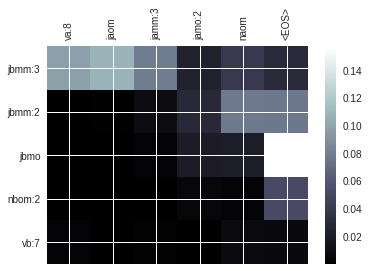


> ja:17 ja:4 na:17 na:7 ra:9 va:2 ja:19 jamm:1 namo:3
= jb:17 jb:4 nb:7 nb:17 rb:9 jb:19 jbmm:2 nbmo vb:2
< jb:17 jb:17 nb:6 nbmo rb:9 jbmm:2 jbmm:2 nbmo vb:2


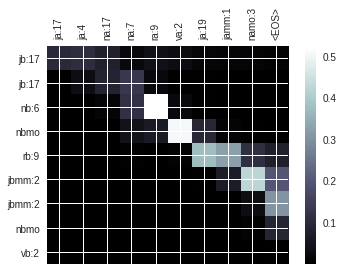


> ramm:1 va:3 namo:1 namm:2 ramm:2
= rbmm:1 rbmm:3 nbmm:1 nbmo vb:3
< rbmm:1 rbmm:1 nbmm:1 nbmo vb:3


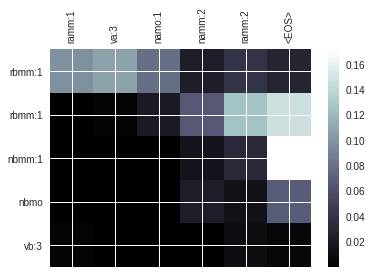


> ra:18 ra:14 ra:15 va:19 ramo:2
= rb:18 rb:14 rb:15 rbmo vb:19
< rb:18 rbmo rbmo rbmo vb:19


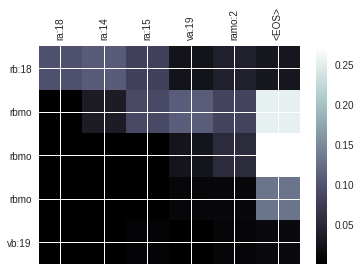


> ja:18 namm:3 namm:3 va:9 namm:2 na:9
= jb:18 nbmm:2 nbmm:3 nb:9 nbmm:3 vb:9
< jb:18 nbmm:1 nbmm:3 nb:9 nbmm:3 vb:9


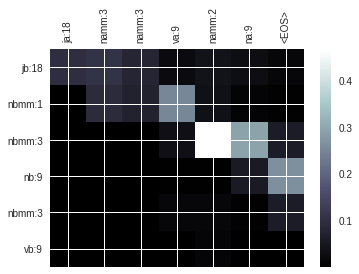


> ja:9 na:18 na:16 ja:3 ja:15 vamm:1 namm:2 namm:1
= jb:15 jb:3 jb:9 nb:16 nb:18 nbmm:3 nbmm:3 vbmm:2
< jb:9 jb:3 jb:3 nb:16 nb:18 nbmm:3 nbmm:3 vbmm:1


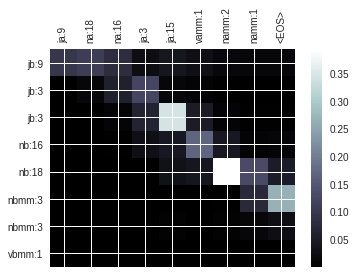


> ra:8 va:5 ja:8 na:9 na:19
= rb:8 jb:8 nb:19 nb:9 vb:5
< rb:8 jb:8 nb:19 nb:9 vb:5


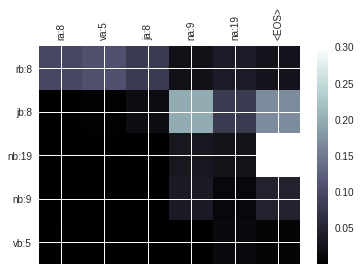


> na:3 ramm:1 vamm:2 jamm:2 namm:3
= nb:3 rbmm:2 jbmm:1 nbmm:2 vbmm:2
< nb:3 rbmm:2 jbmm:2 nbmm:3 vbmm:2


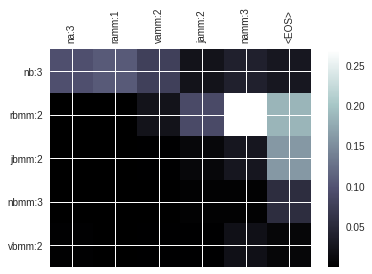


> namm:2 namm:1 ra:7 vamo:3 ra:11
= nbmm:2 nbmm:2 rb:11 rb:7 vbmo
< nbmm:2 nbmm:3 rb:7 rb:11 vb:16


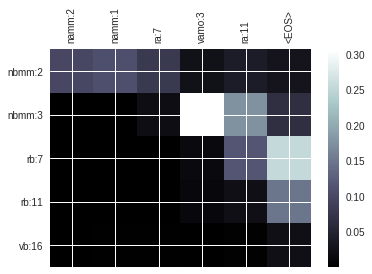


> na:18 na:9 raom va:9 na:10 namo:3 jamm:1 ramm:3
= nb:9 nb:18 rbmm:3 rbom:1 jbmm:1 nbmo nb:10 vb:9
< nb:10 nb:9 rb:0 jbmm:2 jbmm:1 nbmo nb:10 vb:9


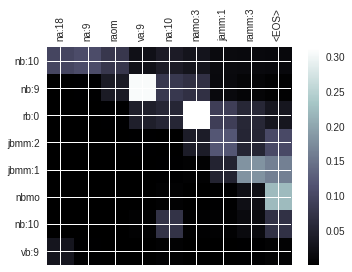

In [39]:
evaluate_random(nmt_model, 0, 1)